# KM4 - preprocessing tektu

In [1]:
#!pip install pyspellchecker==0.5.6

In [2]:
#!pip install wordcloud

In [3]:
#!pip install gensim

In [4]:
#!pip install yellowbrick

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
from nltk.stem import PorterStemmer
import string
import re
import cv2
from spellchecker import SpellChecker
from wordcloud import WordCloud
import copy
import zipfile
from gensim.models import Word2Vec
from yellowbrick.text import PosTagVisualizer
from tqdm.notebook import tqdm
import itertools

## Analiza tekstu

Pomocne artykuły: 
* https://machinelearningknowledge.ai/11-techniques-of-text-preprocessing-using-nltk-in-python/
* https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
* https://medium.com/swlh/word-embedding-word2vec-with-genism-nltk-and-t-sne-visualization-43eae8ab3e2e

### NLP

Nlp składa się z kilku części. Można je wywoływać pojedyńczo, bądź użyć funkcji `text_preprocessing`, która wykonuję cały preprocessing, składający się z: 
1. zamiana tekstu na małe litery
2. usunięcie numerów w bazie danych
3. usunięcie znaków interpunkcyjnych
4. usuniecie nadmiernych spacji
5. tokenizacja
7. usunięcie "stopwords"

W lemmatyzacji używam WordNetLemmatizer z biblioteki nltk

W stemming używam PorterStemmer z biblioteki nltk

In [6]:
# Fuction to process data
# to lower case
def to_lower_case(df_col): 
    return df_col.str.lower()

# Remove numbers - do apply
def remove_numbers(df_apply):
    result = re.sub(r'\d+', '', df_apply)
    return result

# remove punctuation
def remove_punctuation(df_col):
    translator = str.maketrans('', '', string.punctuation)
    return df_col.str.translate(translator)

# remove whitespace from text
def remove_whitespace(df_col):
    return  " ".join(df_col.str.split())

# check spelling
def spell_check(df_apply):
    
    result = []
    spell = SpellChecker()
    for word in df_apply:
        correct_word = spell.correction(word)
        result.append(correct_word)
    return result

# remove stopwords function - do apply
def remove_stopwords(df_apply):
    result = []
    for token in df_apply:
        if token not in stopwords.words('english'):
            result.append(token)
            
    return result

# preprocessing with all above
def text_preprocessing(data, col, verbose = False): 
    df = copy.deepcopy(data)
    tqdm.pandas(disable=not verbose)
    # to lower case
    if verbose: print("to lower case")
    df[col] = to_lower_case(df[col])
    # remove numbers
    if verbose: 
        print("removing numbers")
    df[col]=df[col].progress_apply(remove_numbers)
    # remove punctuation
    if verbose: print("removing punctuation")
    df[col] = remove_punctuation(df[col])
    # remove whitespace from text
    if verbose: print("removing whitespace from text")
    df[col] = remove_punctuation(df[col])
    # Tokenization
    if verbose: print("tokenizating")
    df[col]=df[col].progress_apply(lambda x: word_tokenize(x))
    # remove stopwords
    if verbose: print("removing stopwords")
    df[col]=df[col].progress_apply(remove_stopwords)
    return df
  
# part of speech
def part_of_speech(df_apply): 
    return nltk.pos_tag(df_apply)

# word2vec
def word2vec(df_col): 
    # Create CBOW model
    return Word2Vec(df_col, min_count = 1, window = 5, vector_size=100)

#Lemmatization
def lemmatization(df_apply):
    
    result=[]
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(df_apply):
        pos=tag[0].lower()
        
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
            
        result.append(wordnet.lemmatize(token,pos))
    
    return result

# stemming
def stemming(df_apply):
    porter = PorterStemmer()
    
    result=[]
    for word in df_apply:
        result.append(porter.stem(word))
    return result

# full preprocessing
def full_data_preprocessing(df, col, verbose = False):
    tqdm.pandas(disable=not verbose)
    # initial preprocessing
    df_processed = text_preprocessing(df, col, verbose)
    #lemmatization
    if verbose: print("Calculating stemming")
    df_processed["stemming_lemmatization"]=df_processed[col].progress_apply(stemming)
    # stemming
    if verbose: print("Calculating lemmatization")
    df_processed["stemming_lemmatization"]=df_processed[col].progress_apply(lemmatization)
    #pos
    if verbose: print("Calculating POS")
    df_processed["pos"] = df_processed[col].progress_apply(part_of_speech)
    if verbose: print("Calculating POS with stemming and lemmatization")
    df_processed["pos_stemming_lemmatization"] = df_processed["stemming_lemmatization"].progress_apply(part_of_speech)

    return df_processed

In [7]:
# functions to visualize 
# Wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords.words('english'),
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(data.to_string())

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

# distibution of part to speech 
def show_pos(df_col): 
    plt.figure(figsize = (12,5))
    viz = PosTagVisualizer()
    viz.fit([df_col])
    viz.show()
    plt.show()
    
# TSNE plot for word2vec
def tsne_plot(model, vocab = None):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    #vocab = model.wv.key_to_index if vocab_size == None else dict(itertools.islice(model.wv.key_to_index.items(), vocab_size))
    vocab = model.wv.key_to_index if vocab == None else vocab
    
    for word in vocab: 
        tokens.append(model.wv[word])
        labels.append(word)
        
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
            xy=(x[i], y[i]),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    
    plt.savefig('wordvec.png', dpi=1200)
    plt.show()

In [8]:
#What's stopword to nltk
print("Words, that are taken as stopwords: ")
print(stopwords.words('english'))

Words, that are taken as stopwords: 
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', '

## Dla transkrypcji z REFLACX

In [9]:
# wczytanie danych reflacx: 

REFLACX_FILE_NAME = "../KM1/reflacx/reflacx-reports-and-eye-tracking-data-for-localization-of-abnormalities-in-chest-x-rays-1.0.0"
REFLACX_MAIN_PATH = "/main_data"
utf_decode = "utf-8"

text = []
with zipfile.ZipFile(REFLACX_FILE_NAME+".zip") as archive:
    for file in archive.namelist(): 
        if file.endswith("transcription.txt"):
            with archive.open(file) as f:
                lines = f.readlines()
            if len(lines)>1: print(file)
            text.append(lines[0].decode(utf_decode))

text
reflacx_tran = pd.DataFrame({"text": text})
reflacx_tran.head(5)

,text
0,support apparatus. no pneumothorax. enlarged c...
1,lines and tubes in satisfactory position. lung...
2,right subclavian catheter is noted with tip in...
3,right subclavian vein approach central venous ...
4,the right subclavian vein catheter terminates ...


### Preprocessing data

In [10]:
# Preprocessing
reflacx_tran_pro = full_data_preprocessing(reflacx_tran, "text", True)
reflacx_tran_pro.head()

to lower case
removing numbers


  0%|          | 0/3032 [00:00<?, ?it/s]

removing punctuation
removing whitespace from text
tokenizating


  0%|          | 0/3032 [00:00<?, ?it/s]

removing stopwords


  0%|          | 0/3032 [00:00<?, ?it/s]

Calculating stemming


  0%|          | 0/3032 [00:00<?, ?it/s]

Calculating lemmatization


  0%|          | 0/3032 [00:00<?, ?it/s]

Calculating POS


  0%|          | 0/3032 [00:00<?, ?it/s]

Calculating POS with stemming and lemmatization


  0%|          | 0/3032 [00:00<?, ?it/s]

,text,stemming_lemmatization,pos,pos_stemming_lemmatization
0,"[support, apparatus, pneumothorax, enlarged, c...","[support, apparatus, pneumothorax, enlarge, ca...","[(support, NN), (apparatus, NN), (pneumothorax...","[(support, NN), (apparatus, NN), (pneumothorax..."
1,"[lines, tubes, satisfactory, position, lung, v...","[line, tube, satisfactory, position, lung, vol...","[(lines, NNS), (tubes, NNS), (satisfactory, JJ...","[(line, NN), (tube, NN), (satisfactory, JJ), (..."
2,"[right, subclavian, catheter, noted, tip, svc,...","[right, subclavian, catheter, note, tip, svc, ...","[(right, JJ), (subclavian, JJ), (catheter, NN)...","[(right, JJ), (subclavian, JJ), (catheter, NN)..."
3,"[right, subclavian, vein, approach, central, v...","[right, subclavian, vein, approach, central, v...","[(right, JJ), (subclavian, JJ), (vein, NN), (a...","[(right, JJ), (subclavian, JJ), (vein, NN), (a..."
4,"[right, subclavian, vein, catheter, terminates...","[right, subclavian, vein, catheter, terminate,...","[(right, JJ), (subclavian, JJ), (vein, NN), (c...","[(right, JJ), (subclavian, JJ), (vein, NN), (c..."


###  Results description and visualization

Zacznijmy od analizy POS. 

In [11]:
print("Przykładowy opis transcrypcji oraz jej wygląd po POS: ")
print("\nOpis: ", reflacx_tran["text"][5])
print("\nPOS: ", reflacx_tran_pro["pos"][5])

Przykładowy opis transcrypcji oraz jej wygląd po POS: 

Opis:  mediastinal contours and heart size within normal limits. lung volumes are normal. no consolidation or pleural effusion. no pneumothorax. no acute osseous abnormality.

POS:  [('mediastinal', 'JJ'), ('contours', 'NNS'), ('heart', 'NN'), ('size', 'NN'), ('within', 'IN'), ('normal', 'JJ'), ('limits', 'NNS'), ('lung', 'VBP'), ('volumes', 'NNS'), ('normal', 'JJ'), ('consolidation', 'NN'), ('pleural', 'JJ'), ('effusion', 'NN'), ('pneumothorax', 'NN'), ('acute', 'VBP'), ('osseous', 'JJ'), ('abnormality', 'NN')]


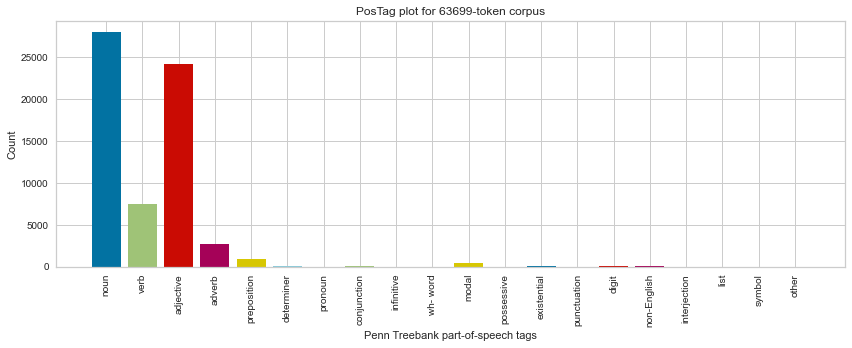

In [12]:
# bar chart of part of speech
show_pos(reflacx_tran_pro["pos"])

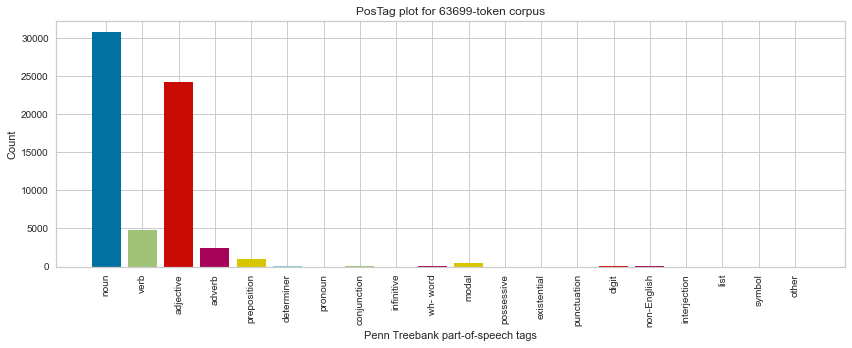

In [13]:
# bar chart of part of speech after stemming and lemmatization
show_pos(reflacx_tran_pro["pos_stemming_lemmatization"])

Okazuję się, że najwięcej jest rzeczowników oraz przymiotników. Następnie mamy znacznie mniejsza ilość czasowników oraz przysłówków. 

Naszymi danymi są opisy zmian płucnych ze zdjęć tomografii komputerowej. Fakt, że sa to dane opisowe wyjaśnia znaczną ilość rzeczowników oraz przymiotników. Z przykładu widzimy również, że przy opisie omija się czasowniki, co tłumaczy dużą różnicę w wynikach. Mniejsza ilośc przysłówków można tłumaczyć tym, że dane są diagnozą schorzenia a nie receptą na wylecznie. W związku z tym opisy nie odpowiadają na pytania *jak?*, tylko *co?* widac na zdjęciu oraz *jakie?* to jest. 


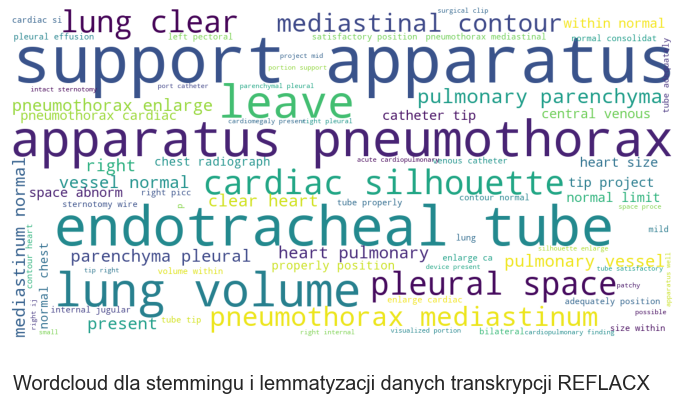

In [14]:
# show wordcloud
show_wordcloud(reflacx_tran_pro["stemming_lemmatization"], "Wordcloud dla stemmingu i lemmatyzacji danych transkrypcji REFLACX")

Widzimy wiele medycznych określeń związanych z płucamu, jak na przykład: 
* mediastinum (śródpiersie)
* pneumothorax (odma płucna)
* endotracheal (dotchawicza)

Są również słowa opisujące sprzęt medyczne takie jak: 
* catheter tip (końcówka cewnika)
* apparatus (aparatura/przyrząd)


D:\uczelnia_programowanie\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
D:\uczelnia_programowanie\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


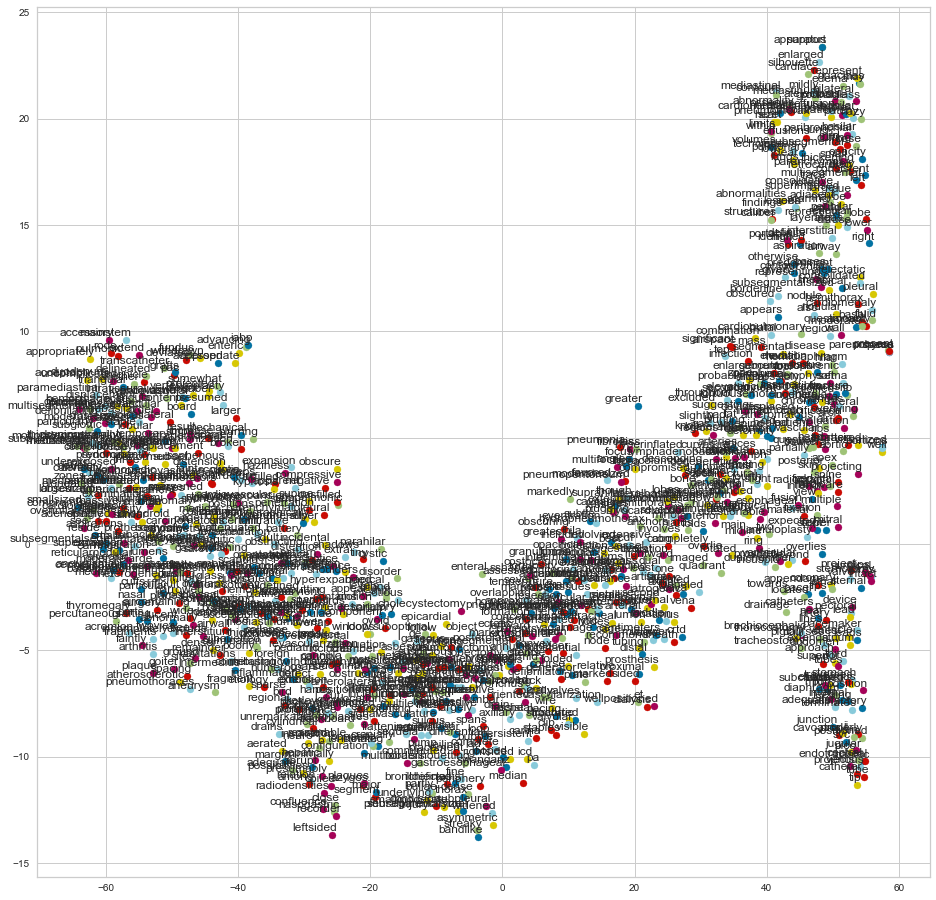

In [16]:
w2v_model = word2vec(reflacx_tran_pro["text"])
tsne_plot(w2v_model)